In [1]:
# Imports
from copy import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import os
import pandas as pd
from scipy import integrate
from scipy import interpolate
import csv
import math

import MARIGOLD as mgd
from MARIGOLD import Condition

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Settings
wd = r"H:\TRSL-H\NEUP\U-bend CFD\Results\NEUP"
resolution = 100

# Profile plot settings
grayed = (0.5, 0.5, 0.5, 0.3)
ghosted = (0.0, 0.0, 0.0, 0.0)

# Contour plot settings
cmap = 'turbo'
vmin = 0
vmax = 1.4
levels = 100
figsize = (7, 7)

# Quiver plot settings
lc = 'black'
width = 0.0025
scale = 5              # Quiver scale, smaller = bigger arrows

In [3]:
# Functions

def is_file_type(file_path, file_extension):
    return os.path.splitext(file_path)[1].lower() == file_extension.lower()

def extract_data(wd):

    all_data = {}
    for fi in mgd.listdir_abs(wd):
        # print(fi)
        if is_file_type(fi,'.csv'):
            vals = pd.read_csv(fi, skiprows=5)
            rd = float(fi.split('\\')[-1].split('_')[0].replace('rd', ''))
            Ub = float(fi.split('\\')[-1].split('_')[1].replace('vf', ''))
            loc = str(fi.split('\\')[-1].split('_')[2])
            ver = float(fi.split('\\')[-1].split('_')[3].replace('v', ''))
            author = str(fi.split('\\')[-1].split('_')[-1].replace('.csv', ''))

            if rd not in all_data:
                all_data[rd] = {}
            if Ub not in all_data[rd]:
                all_data[rd][Ub] = {}
            if loc not in all_data[rd][Ub]:
                all_data[rd][Ub][loc] = {}
            if ver not in all_data[rd][Ub][loc]:
                all_data[rd][Ub][loc][ver] = {}
            
            all_data[rd][Ub][loc][ver][author] = vals
    
    all_data = {
        rd: {
            Ub: {
                loc: {
                    ver: {author: all_data[rd][Ub][loc][ver][author] for author in sorted(all_data[rd][Ub][loc][ver])}
                    for ver in sorted(all_data[rd][Ub][loc])
                } for loc in sorted(all_data[rd][Ub])
            } for Ub in sorted(all_data[rd])
        } for rd in sorted(all_data)
    }

    return(all_data, rd, Ub, loc, ver, author)

def extract_params(data,rd,author,loc):
    if author == 'NEUP':
        LU = 30
        LD = 5

        # if rd == 50:
        #     LU = 10
            
    elif author == 'Quan':
        # LU = 85.9 - 80      # True
        LU = 85.9           # Only really used to offset origin
        LD = 80
    
    us = data[' Velocity u [ m s^-1 ]']
    us = us.to_numpy()
    vs = data[' Velocity v [ m s^-1 ]']
    vs = vs.to_numpy()
    ws = data[' Velocity w [ m s^-1 ]']
    ws = ws.to_numpy()
    yplus = data[' Yplus']
    yplus = yplus.to_numpy()

    if ' Pressure [ Pa ]' in data:
        p = data[' Pressure [ Pa ]']
        p = p.to_numpy()
    else:
        p = None

    if loc == "inlet":
        xs = data['X [ m ]']
        xs = xs.to_numpy() / 0.0127
        ys = data[' Y [ m ]']
        ys = ys.to_numpy() / 0.0127
        zs = data[' Z [ m ]']
        zs = zs.to_numpy() / 0.0127 - LU*2
        
        xs = xs
        ys = ys
        zs = zs
        us = us
        vs = vs
        ws = ws

    elif loc == "apex":
        xs = data['X [ m ]']
        xs = xs.to_numpy() / 0.0127 + rd*2
        ys = data[' Y [ m ]']
        ys = ys.to_numpy() / 0.0127
        zs = data[' Z [ m ]']
        zs = zs.to_numpy() / 0.0127 - rd*2 - LU*2       # *2 to account for the fact that we're dividing by r, not D

        x0 = xs
        y0 = ys
        z0 = zs
        u0 = us
        v0 = vs
        w0 = ws

        xs = z0
        ys = y0
        zs = -x0
        us = w0
        vs = v0
        ws = -u0

    elif loc == "exit":
        xs = data['X [ m ]']
        xs = xs.to_numpy() / 0.0127 + rd*2*2
        ys = data[' Y [ m ]']
        ys = ys.to_numpy() / 0.0127
        zs = data[' Z [ m ]']
        zs = zs.to_numpy() / 0.0127 - LU*2

        xs = -xs
        ys = ys
        zs = -zs
        us = -us
        vs = vs
        ws = -ws
    
    return(xs, ys, us, vs, ws, yplus, p)

def extract_interpolant(xs,ys,us,vs,ws,p):
    linear_interpolant_u = interpolate.LinearNDInterpolator(list(zip(xs, ys)), us, fill_value=0)
    linear_interpolant_v = interpolate.LinearNDInterpolator(list(zip(xs, ys)), vs, fill_value=0)
    linear_interpolant_w = interpolate.LinearNDInterpolator(list(zip(xs, ys)), ws, fill_value=0)

    if p is not None:
        linear_interpolant_p = interpolate.LinearNDInterpolator(list(zip(xs, ys)), p, fill_value=0)

    return(linear_interpolant_u, linear_interpolant_v, linear_interpolant_w, linear_interpolant_p)

def setup(module):
    if module == 1:
        x_plot = np.linspace(-1, 1, resolution)
        y_plot = np.zeros(x_plot.size)

        ls = mgd.line_cycle()
        cs = mgd.color_cycle()

        plt.figure()
        plt.xlabel(r'$r/R$ [-]')
        plt.ylabel(r'$v_{f,z} / U_{f,b}$ [-]')
        plt.xlim([-1, 1])
        plt.ylim([vmin, vmax])

    else:
        x_plot = np.linspace(-1, 1, resolution)
        y_plot = np.linspace(-1, 1, resolution)

        ls = None
        cs = None

    X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

    return(x_plot, y_plot, X_plot, Y_plot, ls, cs)

def plot_string(rds, Ubs, locs, vers, authors, rd, Ub, loc, ver, author, module):
    rd_string = rf'$R_c/D = {rd}$'
    Ub_string = rf'$U_b = {Ub:.1f} [m/s]$'
    loc_string = rf'U-bend {loc}'
    ver_string = rf'Ver. {ver}'
    author_string = rf'Author: {author}'

    if module == 1 or module == 2:
        title_string_A = ["Normalized streamwise velocity"]
        title_string_B = []
    elif module == 3:
        title_string_A = ["Swirl Intensity vs. Radius of Curvature"]
        title_string_B = []

    label_string = []
    
    # Only add rd and ver if module is not 3
    if module != 3:
        if len(rds) > 1:
            label_string.append(rd_string)
        else:
            title_string_B.append(rd_string)
    
    if len(Ubs) > 1:
        label_string.append(Ub_string)
    else:
        title_string_B.append(Ub_string)
    
    if len(locs) > 1:
        label_string.append(loc_string)
    else:
        title_string_A.append(loc_string)
    
    # Only add ver if module is not 3
    if module != 3:
        if len(vers) > 1:
            label_string.append(ver_string)
        else:
            title_string_B.append(ver_string)
    
    if len(authors) > 1:
        label_string.append(author_string)
    else:
        title_string_B.append(author_string)

    title_string_A = ', '.join(title_string_A)
    title_string_B = ', '.join(title_string_B)

    label_string = ', '.join(label_string)
    title_string = '\n'.join([title_string_A, title_string_B])

    return (title_string, label_string)

def integrand_uv(y,x):
    return (linear_interpolant_u(x,y)+linear_interpolant_v(x,y))**2

def integrand_wv(y,z):
    return (linear_interpolant_w(z,y)+linear_interpolant_v(z,y))**2

def upper_bound(x):
    return np.sqrt(1-x**2)

def lower_bound(x):
    return -np.sqrt(1-x**2)

def compute_swirl(xs,ys):
    I_slice = []

    for x in xs[1:-1]:
        y_slice = filter(lambda q: q >= lower_bound(x) and q <= upper_bound(x), ys)
        y_slice = np.array(list(y_slice))

        igs = integrand_uv(y_slice,x)
        
        I_slice.append(integrate.simpson(y=igs, x=y_slice))

    num = integrate.simpson(y=I_slice, x=xs[1:-1])
    den = (Ub**2) * math.pi

    Is = num/den        # Swirl intensity
    
    return Is

def axial_pressure(xs,ys):
    lavg = []

    for x in xs[1:-1]:
        y_slice = filter(lambda q: q >= lower_bound(x) and q <= upper_bound(x), ys)
        y_slice = np.array(list(y_slice))

        navg = linear_interpolant_p(x,y_slice)
        
        lavg.append(integrate.simpson(y=navg, x=y_slice))

    num = integrate.simpson(y=lavg, x=xs[1:-1])
    den = math.pi

    aavg_p = num/den
    
    return aavg_p

In [41]:
# Inputs

module = 1          # 1: velocity profiles, 2: contours, 3: swirl intensity, 4: calc dp
verify = False
save_to_csv = False
logopt = False

gray_rds = []
ghost_rds = [3, 4.5, 6]#[12, 15, 27, 50]

# rds = [9, 12, 15, 27.0, 50]
Ubs = [4]
# locs = ["inlet", "apex", "exit"]
locs = ["exit"]
vers = [4.2]         # 0: Quan, 3: Old mesh, old CCL, 3.1: New mesh, old CCL, 4: New mesh, new CCL, 4.1: Old mesh, new CCL
authors = ["NEUP"]

rds = [3, 4.5, 6, 9, 12, 15, 27, 50]
# locs = ["exit"]

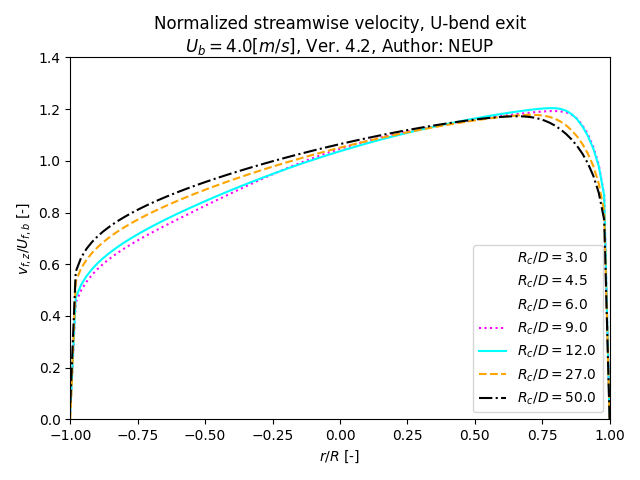

In [42]:
all_data, rd, Ub, loc, ver, author = extract_data(wd)
x_plot, y_plot, X_plot, Y_plot, ls, cs = setup(module)

Is_dict = {}

for rd, Ub_dict in all_data.items():
    if rd not in rds:
        continue
    for Ub, loc_dict in Ub_dict.items():
        if Ub not in Ubs:
            continue
        for loc, ver_dict in loc_dict.items():
            if loc not in locs:
                continue
            for ver, author_dict in ver_dict.items():
                if ver not in vers:
                    continue
                for author, data in author_dict.items():
                    if rd == 9 and ver == 3:
                        continue
                    xs, ys, us, vs, ws, yplus, p = extract_params(data,rd,author,loc)
                    
                    if verify:
                        print(f"Verify: {min(xs)} < X < {max(xs)}\t{min(ys)} < Y < {max(ys)}")

                    if module == 1:
                        linear_interpolant_u, linear_interpolant_v, linear_interpolant_w, linear_interpolant_p = extract_interpolant(xs,ys,us,vs,ws,p)
                        w_plot = linear_interpolant_w(x_plot,y_plot)
                            
                        if rd in gray_rds:
                            linestyle = next(ls)
                            color = grayed
                            dummy = next(cs)
                        elif rd in ghost_rds:
                            linestyle = next(ls)
                            color = ghosted
                            dummy = next(cs)
                        else:
                            linestyle = next(ls)
                            color = next(cs)
                        
                        # Positive is outer
                        title_string, label_string = plot_string(rds,Ubs,locs,vers,authors,rd,Ub,loc,ver,author,module)
                        plt.plot(x_plot, w_plot/Ub, label = label_string, linestyle = linestyle, color = color)
                        plt.title(title_string, wrap = True)
                        plt.legend()
                        plt.tight_layout()

                    elif module == 2:
                        linear_interpolant_u, linear_interpolant_v, linear_interpolant_w, linear_interpolant_p = extract_interpolant(xs,ys,us,vs,ws,p)
                        U_plot = linear_interpolant_u(X_plot,Y_plot)
                        V_plot = linear_interpolant_v(X_plot,Y_plot)
                        W_plot = linear_interpolant_w(X_plot,Y_plot)

                        # Positive is outer
                        title_string, label_string = plot_string(rds,Ubs,locs,vers,authors,rd,Ub,loc,ver,author,module)
                        fig, ax = plt.subplots(figsize = figsize)
                        mpble = ax.contourf(X_plot, Y_plot, W_plot/Ub, levels = levels, vmin = vmin, vmax = vmax, cmap = cmap)
                        fig.colorbar(mpble, label = r'$v_{f,z} / U_{fb}$ [-]', ticks = np.arange(0, vmax + 0.01, 0.2))
                        ax.quiver(X_plot, Y_plot, U_plot, V_plot, color = lc, scale = scale, width = width)
                        
                        plt.title('\n\n'.join([title_string, label_string]))
                        plt.xlabel('x/R [-]')
                        plt.ylabel('y/R [-]')
                        plt.axis('square')
                        plt.tight_layout()
                        plt.show()

                    elif module == 3:
                        us = np.abs(us)
                        vs = np.abs(vs)
                        ws = np.abs(ws)
                        linear_interpolant_u, linear_interpolant_v, linear_interpolant_w, linear_interpolant_p = extract_interpolant(xs,ys,us,vs,ws,p)

                        Is = compute_swirl(x_plot,y_plot)    # Sample from linear interpolants and use Simpson's rule
                        Is_dict.setdefault(rd, {}).setdefault(Ub, {}).setdefault(loc, {}).setdefault(ver, {})[author] = Is
                        
                        print(f"rd: {rd:<10} vf: {Ub:<10} loc: {loc:<10} ver: {ver:<10} author: {author:<10} Is: {Is:<10.2e} Is: {Is}")

                        if save_to_csv:
                            # Only create the file and write headers once
                            if 'csv_writer_initialized' not in globals():
                                csv_filename = 'swirl_output.csv'
                                write_headers = not os.path.isfile(csv_filename)
                                csv_file = open(csv_filename, mode='a', newline='')
                                csv_writer = csv.writer(csv_file)
                                if write_headers:
                                    csv_writer.writerow(['rd', 'Ub', 'loc', 'ver', 'author', 'Is (scientific)', 'Is (full)'])
                                csv_writer_initialized = True  # So we don't reinit in each loop
                            
                            csv_writer.writerow([rd, Ub, loc, ver, author, f"{Is:.2e}", Is])
                        
                    elif module == 4:
                        linear_interpolant_u, linear_interpolant_v, linear_interpolant_w, linear_interpolant_p = extract_interpolant(xs,ys,us,vs,ws,p)

                        aavg_p = axial_pressure(x_plot,y_plot)

                        print(f"rd: {rd:<10} vf: {Ub:<10} loc: {loc:<10} ver: {ver:<10} author: {author:<10} p: {aavg_p}")

if module == 1:
    plt.show()

elif module == 3:
    # Initialize plot
    plt.figure()
    plt.xlabel(r'$R_c/D$ [-]')
    plt.ylabel(r'$I_s$ [-]')

    if logopt == True:
        plt.semilogy()

    # Style cycles
    ls = mgd.line_cycle()
    cs = mgd.color_cycle()
    ms = mgd.marker_cycle()

    # For storing consistent styles
    plot_styles = {}

    # For storing curve data grouped by (loc, Ub, author) instead of (loc, Ub, ver, author)
    plot_data = {}

    for rd, Ub_dict in Is_dict.items():
        if rd not in rds:
            continue
        for Ub, loc_dict in Ub_dict.items():
            if Ub not in Ubs:
                continue
            for loc, ver_dict in loc_dict.items():
                if loc not in locs:
                    continue
                for ver, author_dict in ver_dict.items():
                    if ver not in vers:
                        continue
                    for author, Is in author_dict.items():
                        if rd == 9 and ver == 3:
                            continue
                        key = (loc, Ub, author)  # Remove version from the key

                        if key not in plot_styles:
                            plot_styles[key] = {
                                "linestyle": next(ls),
                                "color": next(cs),
                                "marker": next(ms),
                            }

                        if key not in plot_data:
                            plot_data[key] = {"rds": [], "Is": [], "meta": (rd, Ub, loc, ver, author)}

                        plot_data[key]["rds"].append(rd)
                        plot_data[key]["Is"].append(Is)

    # Plot everything
    for key, data in plot_data.items():
        loc, Ub, author = key  # Extract without version
        rd_sample = data["rds"][0]  # Just pick the first one for metadata
        rd, Ub, loc, ver, author = data["meta"]
        style = plot_styles[key]

        # Generate title and label strings
        title_string, label_string = plot_string(rds, Ubs, locs, vers, authors, rd, Ub, loc, ver, author, module)

        plt.plot(
            data["rds"],
            data["Is"],
            label=label_string,  # Version is now not considered
            linestyle=style["linestyle"],
            color=style["color"],
            marker=style["marker"],
            markersize=6,
        )

    # Use the first group's title_string for the plot title
    first_meta = next(iter(plot_data.values()))["meta"]
    rd, Ub, loc, ver, author = first_meta
    title_string, _ = plot_string(rds, Ubs, locs, vers, authors, rd, Ub, loc, ver, author, module)

    plt.title(title_string, wrap=True)
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()

    if 'csv_file' in globals():
        csv_file.close()